<a href="https://colab.research.google.com/github/nebojsa-bozanic/OSuM/blob/master/OSuM_Vezba2/OSuM_Vezba2/OSuM_vezba_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Obrada slike u medicini (BMI)</h1>

Literatura: https://moodle.telekom.ftn.uns.ac.rs/course/view.php?id=82

Laboratorijska vežba 2: Manipulacije nad 3D slikom

Potrebne biblioteke: pydicom, cv2, numpy, matplotlib.pyplot, matplotlib.widgets

In [6]:
!git clone https://github.com/nebojsa-bozanic/OSuM.git
%cd /content/OSuM/OSuM_Vezba2/OSuM_Vezba2

Cloning into 'OSuM'...
remote: Enumerating objects: 111, done.
remote: Counting objects: 100% (111/111), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 111 (delta 35), reused 54 (delta 6), pack-reused 0
Receiving objects: 100% (111/111), 28.86 MiB | 27.42 MiB/s, done.
Resolving deltas: 100% (35/35), done.
/content/OSuM/OSuM_Vezba2/OSuM_Vezba2


In [7]:
!pip install pydicom

In [13]:
import pydicom as dicom
import numpy as np
import cv2

from google.colab.patches import cv2_imshow
from IPython.display import clear_output
from time import sleep

1. Video iz DICOM fajla

1.1 Učitati DICOM fajl 0002.dcm i u posebnu promenljivu izvući atribut koji se odnosi na
snimak, tj. sekvencu snimaka u ovom primeru. Koje su dimenzije te promenljive? Koji
je modalitet snimanja u pitanju?

1.2 Reorganizovati redosled dimenzija tako da se dimenzija koja se odnosi na vreme
nalazi na poslednjem mestu. (Ovaj korak nije neophodan.)

1.3 Sačuvati učitanu angiografsku sekvencu u video fajl videoXA.avi.

1.4 Prikazati video napravljen u prethodnom koraku.


2. Učitavanje 3D slike

2.1 Napraviti novi modul slika_3d.py i u njemu funkciju imread_3d za učitavanje 3D slike u formatu .img sa propratnih .hdr fajlom.

2.2 U glavnom modulu učitati sliku iz fajlova 01006_t1_cma.img i 01006_t1_cma.hdr. Kojih dimenzija je ova slika?

2.3 Prikazati presek ove 3D slike u xy ravni, za z=100. Obratiti pažnju da je redosled dimenzija (z,x,y). Koji modalitet snimanja je u pitanju?


3. GUI za prikaz 3D slike u 3 projekcije
GUI za jedanu dimenziju (prikaz_z.py):

3.1 Prikazati presek 3D MRI slike u xy ravni na jednom subplot-u.

3.2 Definisati slajder kojim će se kontrolisati vrednosti preseka po z-osi.

3.3 Definisati callback funkciju koja definiše akciju koja se dešava na promenu vrednosti slajdera. Pozvati tu funkciju.
GUI za 3 dimenzije:

3.4 U modulu slika_3d.py napraviti funkciju imshow_slice koja prikazuje 3D sliku u sva tri preseka. U okviru nje definisati slajdere za promenu vrednosti preseka po svim
dimenzijama.

3.5 U glavnom modulu definisati callback funkcije za sva tri preseka.

3.6 Iskoristiti matplotlib podmodul gridspec za organizaciju subplot-ova.


4. Koordinate na kojima se nalazi sadržaj slike

4.1 Napraviti funkciju koordinate u modulu slika_3d.py koja pronalazi početnu i krajnju koordinatu na kojima se nalazi sadržaj slike. Očitati vrednosti koordinata na kojima počinje i na kojima se završava sadržaj slike, za sve tri dimenzije. Da li se očitane vrednosti slažu sa vrednostima koje su dobijene iz funkcije?

In [ ]:
# 1.1
pd = dicom.dcmread('0002.DCM')
im = pd.pixel_array

# 1.2
im = np.swapaxes(im, 0, 1)
im = np.swapaxes(im, 1, 2)

# 1.3
fourcc = cv2.VideoWriter_fourcc('M', 'J', 'P', 'G')
fps = 10  # frame rate
frame_size = (im.shape[0], im.shape[1])  # dimeznije frejma; ako je izostavljen korak 1.2 prilagoditi ovaj deo
isColour = 0

# Video Writer objekat
video_out = cv2.VideoWriter('videoXA.avi', fourcc, fps, frame_size, isColour)

# zapisivanje frejm po frejm
for i in range(im.shape[2]):
    video_out.write(im[:, :, i])

video_out.release()

# 1.4

# Video Capture objekat
cap = cv2.VideoCapture('videoXA.avi')
clear_output()

while cap.isOpened():  # cap.isOpened bice true ako je inicijalizacija prosla kako treba
    # citanje frejm po frejm; ret - true ako je frejm procitan
    ret, frame = cap.read()
    if not ret:
        break
    # frejm se prikazuje kao slika
    cv2_imshow(frame) # 'Video', 
    # delay nakon koga se prikazuje sledeci frejm - to nizanje frejmova vidimo kao vide0
    sleep(0.1)

cap.release()
cv2.waitKey(0)
cv2.destroyAllWindows()

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider


# 2.1
def imread_3d(img_path, hdr_path):
    f_img = open(img_path, 'rb')
    f_hdr = open(hdr_path, 'rb')

    img = np.fromfile(f_img, np.dtype('uint16'))
    f_hdr.seek(40)  # postavljanje pointera na zeljenu lokaciju
    hdr = np.fromfile(f_hdr, np.dtype('uint16'))

    ndims = hdr[0]
    im_dims = hdr[1:ndims + 1]
    image = img.reshape(im_dims)

    f_img.close()
    f_hdr.close()

    return image


# 3.4
def imshow_slice(img, ax, ndims):
    im_obj = []
    sl_d = []
    for dim in range(ndims):
        # promenljive koje je potrebno definisati u zavisnosti od dimenzije
        if dim == 0:
            # pocetni prikaz za presek po z-osi
            image = img[0, :, :]
            dim_str = 'z'
            # udaljenost slajdera od leve ivice
            axs_l = 0.1
        elif dim == 1:
            # pocetni prikaz za presek po x-osi
            image = img[:, 0, :]
            # slika je 'izvrnuta' po x dimenziji pa je treba ispraviti
            image = np.flipud(image)
            dim_str = 'x'
            # udaljenost slajdera od leve ivice
            axs_l = 0.4
        elif dim == 2:
            # pocetni prikaz za presek po y-osi
            image = img[:, :, 0]
            # slika je 'izvrnuta' po y dimenziji pa je treba ispraviti
            image = np.flipud(image)
            # udaljenost slajdera od leve ivice
            dim_str = 'y'
            axs_l = 0.7

        im_obj_dim = ax[dim].imshow(image, cmap='gray', vmin=img.min(), vmax=img.max())
        im_obj.append(im_obj_dim)
        ax[dim].set_title(dim_str+' presek')
        ax[dim].axis('off')
        ax_d = plt.axes([axs_l, 0.02, 0.2, 0.03])
        sl_d_dim = Slider(ax_d, dim_str, valmin=0, valmax=img.shape[dim] - 1, valinit=0, valstep=1)
        sl_d.append(sl_d_dim)

    return im_obj, sl_d


# 4.1
def koordinate(im, dim):
    c = 1
    # prolaz kroz svaki presek dimenzije dim
    for i in range(im.shape[dim]):
        if dim == 0:
            tmp = im[i, :, :]
        elif dim == 1:
            tmp = im[:, i, :]
        elif dim == 2:
            tmp = im[:, :, i]

        # ukoliko ima makar jedan piksel cija vrednost nije 0 - detektovan sadrzaj slike;
        if tmp.any() and c == 1:
            pocetak = i
            c = 2  # da se ne prebrise koordinata pocetka u sledecoj iteraciji

        # krajnja koordinata se trazi samo ako je vec pronadjen pocetak (c==2)
        if not tmp.any() and c == 2:
            kraj = i-1  # poslednja koordinata na kojoj se nalazio sadrzaj
            break

    return pocetak, kraj





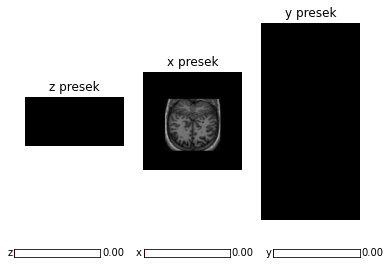

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
'''
# postavljanje foldera u kom se nalazi zeljeni modul (slika_3d.py) na python path
import sys
sys.path.append('putanja do foldera')
'''
import slika_3d

im = slika_3d.imread_3d('01006_t1_cma.img', '01006_t1_cma.hdr')
im = im.astype(np.uint8)

# 3.1
fig, ax = plt.subplots(1, 3)
# kada se tek otvori GUI bice prikazan presek im[0, :, :]
im_objz = ax[0].imshow(im[0, :, :], cmap='gray', vmin=im.min(), vmax=im.max())
ax[0].axis('off')
ax[0].set_title('z presek')

# 3.2
# osa na kojoj ce se nalaziti slajder
ax_sldz = plt.axes([0.1, 0.03, 0.2, 0.03])  # [left, bottom, width, height]
sldz = Slider(ax_sldz, 'z', valmin=0, valmax=im.shape[0]-1, valinit=0, valstep=1)

# kada se tek otvori GUI bice prikazan presek im[0, :, :]
im_objx = ax[1].imshow(im[:, 30, :], cmap='gray', vmin=im.min(), vmax=im.max())
ax[1].axis('off')
ax[1].set_title('x presek')

# 3.2
# osa na kojoj ce se nalaziti slajder
ax_sldx = plt.axes([0.4, 0.03, 0.2, 0.03])  # [left, bottom, width, height]
sldx = Slider(ax_sldx, 'x', valmin=0, valmax=im.shape[1]-1, valinit=0, valstep=1)

# kada se tek otvori GUI bice prikazan presek im[0, :, :]
im_objy = ax[2].imshow(im[:, :, 15], cmap='gray', vmin=im.min(), vmax=im.max())
ax[2].axis('off')
ax[2].set_title('y presek')

# 3.2
# osa na kojoj ce se nalaziti slajder
ax_sldy = plt.axes([0.7, 0.03, 0.2, 0.03])  # [left, bottom, width, height]
sldy = Slider(ax_sldy, 'y', valmin=0, valmax=im.shape[2]-1, valinit=0, valstep=1)

# 3.3
def update_z(val):
    # vrednost sa slajdera
    z = sldz.val
    # azuriranje slike
    img = im[z, :, :]
    im_objz.set_data(img)
    fig.canvas.draw_idle()



# na promenu vrednosti slajdera pozvati callback
sldz.on_changed(update_z)

def update_x(val):
    # vrednost sa slajdera
    x = sldx.val
    # azuriranje slike
    img = im[:, x, :]
    im_objx.set_data(img)
    fig.canvas.draw_idle()


# na promenu vrednosti slajdera pozvati callback
sldx.on_changed(update_x)
# plt.show()


def update_y(val):
    # vrednost sa slajdera
    y = sldy.val
    # azuriranje slike
    img = im[:, :, y]
    im_objy.set_data(img)
    fig.canvas.draw_idle()


# na promenu vrednosti slajdera pozvati callback
sldy.on_changed(update_y)
plt.show()  

In [ ]:
import numpy as np
import slika_3d
import matplotlib.pyplot as plt


def main():

    # 2.2
    im = slika_3d.imread_3d('/Users/aleksandra/Desktop/vezba2/01006_t1_cma.img', '/Users/aleksandra/Desktop/vezba2/01006_t1_cma.hdr')
    im = im.astype(np.uint8)

    # 2.3
    z = 100
    im_z = im[z, :, :]
    plt.figure(1)
    plt.imshow(im_z, cmap='gray', vmin=im_z.min(), vmax=im_z.max())
    plt.axis('off')
    plt.show()

# 3.5
    def update_z(val):
        z = sl_d[0].val
        img = im[z, :, :]
        im_obj[0].set_data(img)
        fig.canvas.draw_idle()

    def update_x(val):
        x = sl_d[1].val
        img = im[:, x, :]
        img = np.flipud(img)
        im_obj[1].set_data(img)
        fig.canvas.draw_idle()

    def update_y(val):
        y = sl_d[2].val
        img = im[:, :, y]
        img = np.flipud(img)
        im_obj[2].set_data(img)
        fig.canvas.draw_idle()

    # 3.6
    fig = plt.figure()
    gs = fig.add_gridspec(2, 2)
    ax_z = fig.add_subplot(gs[0, 0])
    ax_x = fig.add_subplot(gs[1, 0])
    ax_y = fig.add_subplot(gs[:, 1])  # y presek zauzima celu desnu kolonu
    # plt.subplots_adjust(bottom=0.1) # ukoliko je potrebno pomeriti subplot-ove od donje ivice
    ax = [ax_z, ax_x, ax_y]
    im_obj, sl_d = slika_3d.imshow_slice(im, ax, len(im.shape))
    sl_d[0].on_changed(update_z)
    sl_d[1].on_changed(update_x)
    sl_d[2].on_changed(update_y)
    plt.show()

    # 4.1
    z1, z2 = slika_3d.koordinate(im, 0)Laboratorijska
    y1, y2 = slika_3d.koordinate(im, 2)

    return z1, z2, x1, x2, y1, y2


if __name__ == '__main__':
    # ovaj deo koda ce se izvrsiti ukoliko se skripta poziva direktno, a ne ucitava u negde kao modul
    z1, z2, x1, x2, y1, y2 = main()